# Simulations - 1 

In [10]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 30)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [11]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
number.of.covariates = 30
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)

registerDoParallel(cores = 4)
number.of.iters <- 20

offset = 0.1
lambda = 1

In [12]:
GetInitPars <- function(train, q=0.6) {
    index = train$reward > quantile(train$reward, q)
    rqmodel = rq(train$treatment[index] ~ train$covariates[index,] - 1, tau=.5, 
             method="lasso", weights=train$reward[index], lambda = lambda)
    return(coef(rqmodel))
}

# Проблема 1
#### dc_solution решение зависит от начального приближения

In [51]:
train <- GetSimulationData(sample.size, number.of.covariates)
quants = seq(0.05, 0.99, 0.1)
cs = list()
for (q in quants) {
    init.pars = GetInitPars(train, q=q)
    model = dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, lambda, init.pars[-1], init.pars[1])
    cs[[length(cs) + 1]] <- coef(model)
}
cs <- apply(as.data.frame(cs), 2, unlist)
colnames(cs) <- 1:NCOL(cs)

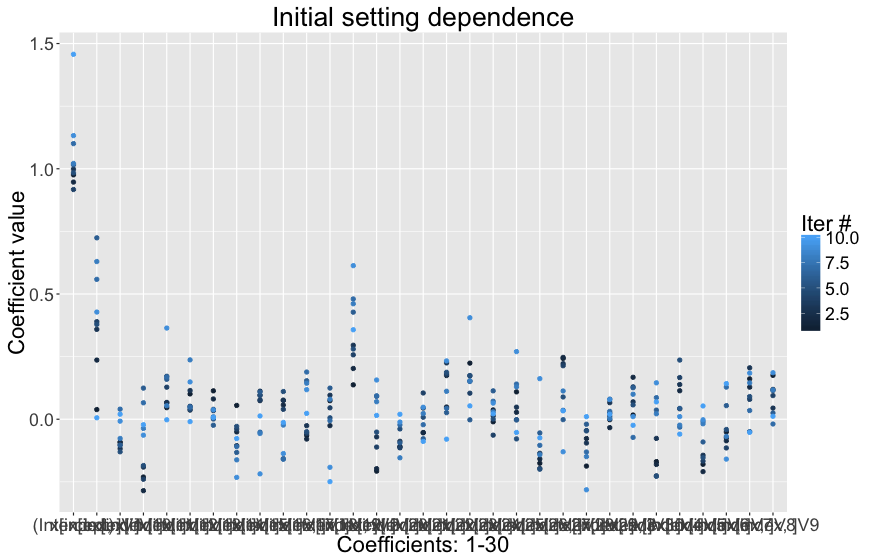

In [5]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/IniValueDependence.pdf", width = 8, height=6 )
ggplot(melt(cs) , aes(X1, value))  + geom_point(aes(colour = X2)) + theme(text = element_text(size=15)) + 
 theme(text = element_text(size=20)) + 
    xlab("Coefficients: 1-30") +
    ylab("Coefficient value") +
    ggtitle("Initial setting dependence") +
    scale_colour_gradient(name="Iter #")
# dev.off()

In [ ]:
# train <- GetSimulationData(sample.size, number.of.covariates)
quants = seq(0.05, 0.8, 0.1)
cs = list()
for (q in quants) {
  opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=GetInitPars(train, q=q), "approximation.eps"=1e-7)
  cs[[length(cs) + 1]] <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
}
cs <- apply(as.data.frame(cs), 2, unlist)
colnames(cs) <- as.factor(1:NCOL(cs))
mcs  <-  melt(cs)
names(mcs) <- c("Coef.num", "Iteration", "Value")

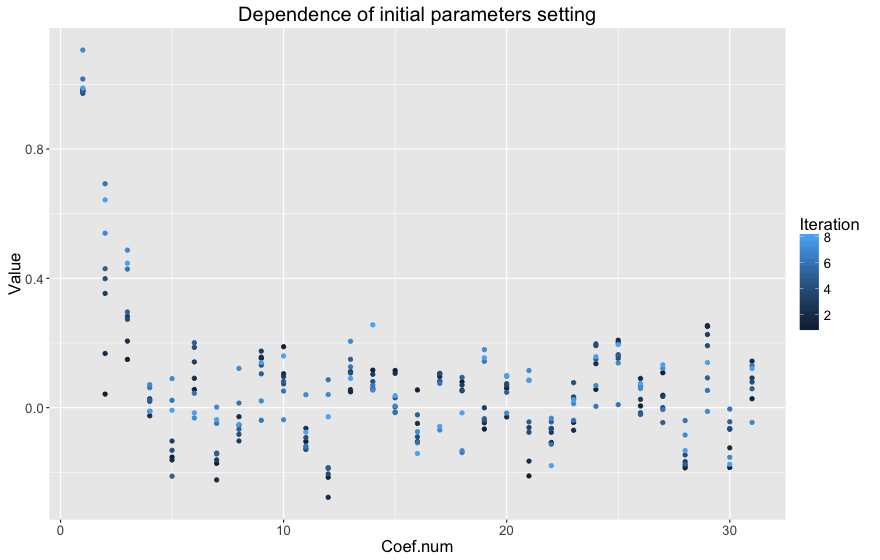

In [25]:
ggplot(mcs, aes(x=Coef.num,  y=Value))  + 
  geom_point(aes(colour = Iteration)) + 
  theme(text = element_text(size=15)) + 
  labs(title="Dependence of initial parameters setting")

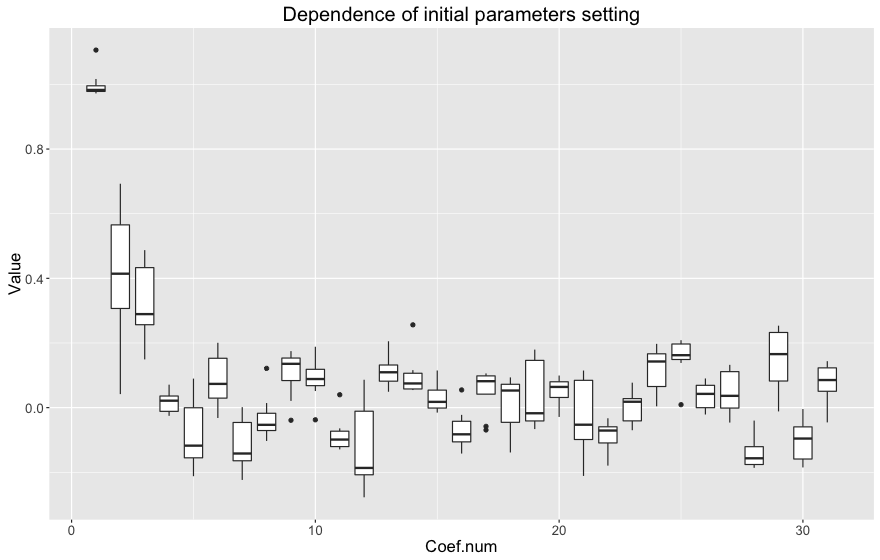

In [38]:
ggplot(mcs, aes(x=Coef.num,  y=Value))  + 
  geom_boxplot(aes(group=Coef.num)) + 
  theme(text = element_text(size=15))  + 
  labs(title="Dependence of initial parameters setting")

# Проблема 2 

In [16]:
dc_loop <- function (x, a, r, epsilon, C0, w_t, b_t) 
{
    w_old = w_t
    b_old = b_t
    w = w_t + 1
    b = b_old + 1
    maxstep = 20
    steps = 0
    while (max((w - w_old)^2, (b - b_old)^2) > 1e-08 && steps < 
        maxstep) {
        steps = steps + 1
        index = which(abs(a - x %*% w_t - b_t) < epsilon)
        if (length(index) < 2) {
            break
        }
        rqmodel = rq(a[index] ~ x[index, ], 0.5, weights = r[index], 
            method = "lasso", lambda = C0)
        w = rqmodel$coefficients[-1]
        b = rqmodel$coefficients[1]
        w_old = w_t
        b_old = b_t
        w_t = w
        b_t = b
    }
    pickedmodel = rqmodel
    return(pickedmodel)
}

In [16]:
global.stat <- list()

test <- GetSimulationData(test.data.sample.size, number.of.covariates)
for (i in seq(1,number.of.iters)) {
    train <- GetSimulationData(sample.size, number.of.covariates)
    init.pars = GetInitPars(train)
    
    opt.params = list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
    pars.dca.true.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    pars.owl <- GetOwlParams(train, lambda, weights = F)
    pars.owl.weights <- GetOwlParams(train, lambda, weights = T)
    pars.owl.dc_loop <- coef(dc_loop(train$covariates[, -1], train$treatment, train$reward, offset, lambda, init.pars[-1], init.pars[1]))
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=TRUE)
#     pars.nr <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
#     opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars, "use.hessian"=FALSE)
#     pars.nr.without.hess <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)
    opt.params = list("opt.func"=NROptimize, "init.pars"=init.pars,  "func"=CauchyObjFunc.2max, "func.grad"=CauchyObjFunc.grad.2max, "func.hess"=CauchyObjFunc.hess.2max)
    pars.cauchy <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda=lambda, opt.hyperparams=opt.params)

    opt.decision <- c(1, 0.5, 0.5 , rep(0, length(pars.owl ) - 3))
    data.list <- list("train"=train, "test"=test)
    params.list  <- list("MM.proper.iters"=pars.dca.true.MM, 
                         "OWL.dc_loop"=pars.owl.dc_loop,
#                          "NR" =  pars.nr,
#                          "NR.without.hess" = pars.nr.without.hess, 
                         "Ideal"=opt.decision,
                         "OWL"=pars.owl, 
                         "Init.pars"=pars.owl, 
                         "Cauchy"=pars.cauchy, 
                         "OWL.weights"=pars.owl.weights
                        ) 
    iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
    global.stat  <- rbind(global.stat, iter.stat)
}

MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  3  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  7  iterations
Code:  3  Message:  Last step could not find a value above the current.
Boundary of parameter space?  
Consider switching to a more robust optimisation method temporarily. 
MML2PenalizedProperIters Converged after  5  iterations
Code:  3  Message:  Last ste

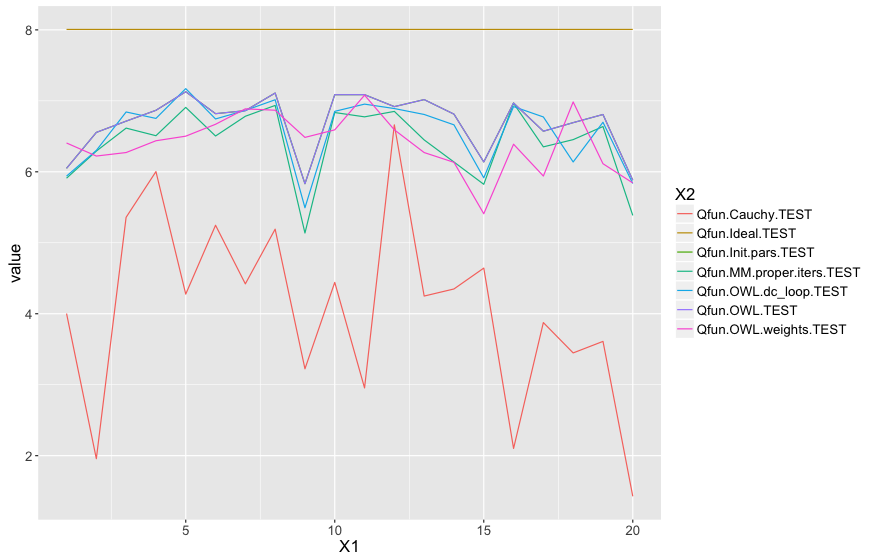

In [17]:
melt = reshape::melt
gl.stat.df <- apply(global.stat, 2, unlist)
vf.train <- melt(gl.stat.df[, grep("VF.*TRAIN", colnames(gl.stat.df))])
vf.test <- melt(gl.stat.df[, grep("VF.*TEST", colnames(gl.stat.df))])
obj.train <- melt(gl.stat.df[, grep("OBJ.*TRAIN", colnames(gl.stat.df))])
obj.test <- melt(gl.stat.df[, grep("OBJ.*TEST", colnames(gl.stat.df))])
q.train <- melt(gl.stat.df[, grep("Q.*TRAIN", colnames(gl.stat.df))])
q.test <- melt(gl.stat.df[, grep("Q.*TEST", colnames(gl.stat.df))])

# ggplot(q.train , aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
ggplot(q.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(vf.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.train, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))
# ggplot(obj.test, aes(X1, value))  + geom_line(aes(colour = X2)) + theme(text = element_text(size=15))

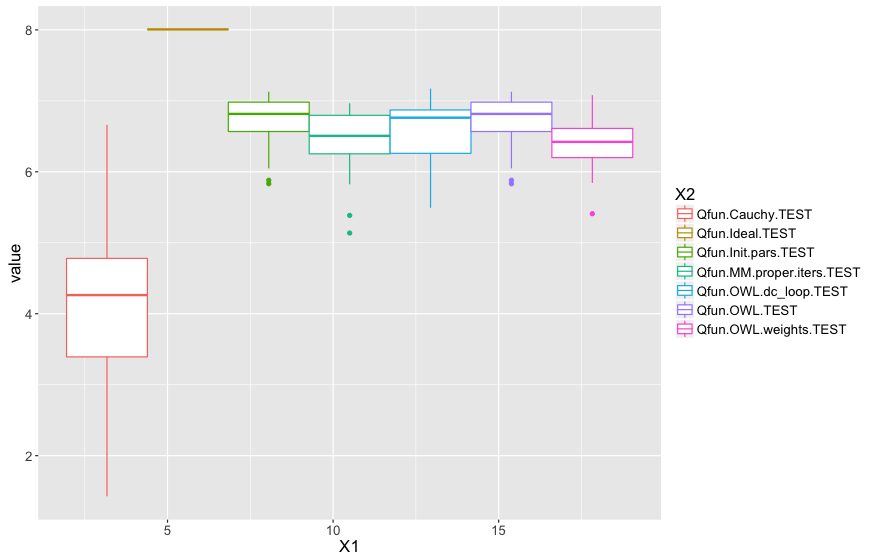

In [18]:
ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + theme(text = element_text(size=15))

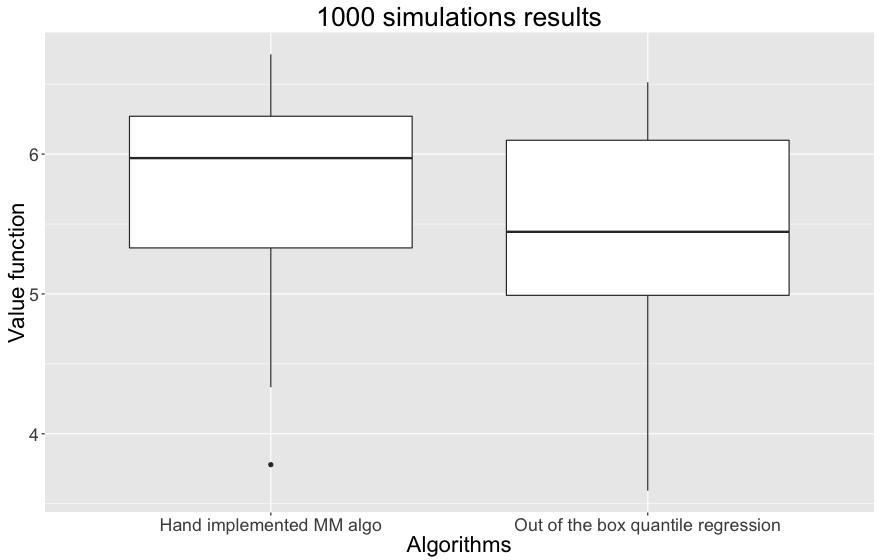

In [44]:
# pdf("~/yandexDisk/DIPLOMA/REPORTS/Presentations/imgs/MMvsRQ.pdf", width = 8, height=6 )
data.to.plot <-  q.test[q.test$X2 %in% c("Qfun.MM.proper.iters.TEST", "Qfun.OWL.dc_loop.TEST"), ]
ggplot(data.to.plot , aes(factor(data.to.plot$X2, labels = c("Hand implemented MM algo", 
                                                             "Out of the box quantile regression")), y=value  )) +  
    geom_boxplot() +  
    theme(text = element_text(size=20)) + 
    xlab("Algorithms") +
    ylab("Value function") +
    ggtitle("1000 simulations results")
# dev.off()

# Big troubles with rq: ACHTUNG !!!!!!!

Quantile regression, который используется в статье **вообще** 
- не использует информацию  о tau !!! 
- А судя по коду, еще и совершенно не учитываются веса!!! 

In [346]:
cfss = coef(rq(data$treatment ~ data$covariates - 1, tau = c(seq(0.1, 0.9, 0.1)), weights = data$reward))
head(cfss)

tau= 0.1     tau= 0.2     tau= 0.3      tau= 0.4
data$covariates(Intercept)  0.269559164  0.461258980 0.6460703760  0.7969177648
data$covariatesV1           0.084993468  0.101562804 0.1502147246  0.1307552975
data$covariatesV2           0.098774917  0.114943535 0.1774762872  0.1860115094
data$covariatesV3           0.041876518  0.031078754 0.0016278706 -0.0133490920
data$covariatesV4           0.004279808 -0.004955390 0.0006184262 -0.0070040480
data$covariatesV5          -0.014509590 -0.004196949 0.0054357252 -0.0009545133
                              tau= 0.5    tau= 0.6     tau= 0.7    tau= 0.8
data$covariates(Intercept)  0.96004193  1.16860110  1.348666603  1.53377470
data$covariatesV1           0.12014702  0.17530754  0.124016504  0.09247840
data$covariatesV2           0.17899222  0.16163674  0.183623259  0.10437682
data$covariatesV3          -0.03132569 -0.04565557 -0.019190527 -0.04720124
data$covariatesV4           0.02959844 -0.01745431 -0.030112699 -0.06259228
data$covariatesV5           0.03256794  0.05455647 -0.008970085 -0.01779000
                               tau= 0.9
data$covariates(Intercept)  1.742917752
data$covariatesV1           0.077167721
data$covariatesV2           0.066931810
data$covariatesV3          -0.022031111
data$covariatesV4          -0.042037041
data$covariatesV5           0.005298628

In [369]:
cfss_lasso = coef(rq(data$treatment ~ data$covariates - 1, tau = c(seq(0.1, 0.9, 0.1)), method = "lasso", weights = data$reward, lambda = lambda))
head(cfss_lasso)

[1] "assuming many taus!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"
[1] "weighted!"


tau= 0.1     tau= 0.2     tau= 0.3      tau= 0.4
data$covariates(Intercept)  0.269559164  0.461258980 0.6460703760  0.7969177648
data$covariatesV1           0.084993468  0.101562804 0.1502147246  0.1307552975
data$covariatesV2           0.098774917  0.114943535 0.1774762872  0.1860115094
data$covariatesV3           0.041876518  0.031078754 0.0016278706 -0.0133490920
data$covariatesV4           0.004279808 -0.004955390 0.0006184262 -0.0070040480
data$covariatesV5          -0.014509590 -0.004196949 0.0054357252 -0.0009545133
                              tau= 0.5    tau= 0.6     tau= 0.7    tau= 0.8
data$covariates(Intercept)  0.96004193  1.16860110  1.348666603  1.53377470
data$covariatesV1           0.12014702  0.17530754  0.124016505  0.09247840
data$covariatesV2           0.17899222  0.16163674  0.183623261  0.10437682
data$covariatesV3          -0.03132569 -0.04565557 -0.019190526 -0.04720124
data$covariatesV4           0.02959844 -0.01745431 -0.030112698 -0.06259228
data$covariatesV5           0.03256794  0.05455647 -0.008970086 -0.01779000
                               tau= 0.9
data$covariates(Intercept)  1.742917752
data$covariatesV1           0.077167721
data$covariatesV2           0.066931810
data$covariatesV3          -0.022031111
data$covariatesV4          -0.042037041
data$covariatesV5           0.005298628

In [260]:
cfss_lasso_another_weights = coef(rq(data$treatment ~ data$covariates - 1, tau = c(seq(0.1, 0.9, 0.1)),  weights = sort(data$reward), lambda = lambda, method="lasso"))
head(cfss_lasso_another_weights)

tau= 0.1    tau= 0.2    tau= 0.3    tau= 0.4
data$covariates(Intercept)  0.99042096  0.99042096  0.99042096  0.99042096
data$covariatesV1           0.01182788  0.01182788  0.01182788  0.01182788
data$covariatesV2           0.02340279  0.02340279  0.02340279  0.02340279
data$covariatesV3          -0.01109298 -0.01109298 -0.01109298 -0.01109298
data$covariatesV4           0.01856877  0.01856877  0.01856877  0.01856877
data$covariatesV5           0.03131871  0.03131871  0.03131871  0.03131871
                              tau= 0.5    tau= 0.6    tau= 0.7    tau= 0.8
data$covariates(Intercept)  0.99042096  0.99042096  0.99042096  0.99042096
data$covariatesV1           0.01182788  0.01182788  0.01182788  0.01182788
data$covariatesV2           0.02340279  0.02340279  0.02340279  0.02340279
data$covariatesV3          -0.01109298 -0.01109298 -0.01109298 -0.01109298
data$covariatesV4           0.01856877  0.01856877  0.01856877  0.01856877
data$covariatesV5           0.03131871  0.03131871  0.03131871  0.03131871
                              tau= 0.9
data$covariates(Intercept)  0.99042096
data$covariatesV1           0.01182788
data$covariatesV2           0.02340279
data$covariatesV3          -0.01109298
data$covariatesV4           0.01856877
data$covariatesV5           0.03131871

### Influence of initial tau (without weights) on initial parameters

Обычный подход к начальному приближению (он же -- результат симуляции) это квантильная медианная регрессия на 40% лучших данных (отнсоительно reward). При этом, как было установлено ранее, эта регрессия не учитывала веса и tau. Попробуем:
    - сравнить начальные веса, как результат квантильной регресси с весами и без весов
    - по результатам предыдущего пункта поиграться с параметром tau

#### 1. Initial params with regularization versus params trained with weights and without regularization

In [448]:
GetOwlParamsWithoutWeights <- function (data, lambda, q = 0.6, t = 0.5) {
    constant = min(quantile(data$raw.reward, q), 0)
    data$weight = data$raw.reward - constant
    index = which(data$raw.reward > quantile(data$raw.reward, q))
    rqmodel = rq(data$treatment[index] ~ data$covariates[index,] - 1, tau = t, method = "lasso", lambda = lambda)
    coefs = coef(rqmodel)
    return(matrix(coefs))
}

In [446]:
GetOwlParamsWithWeightsAndTau <- function (data, q = 0.6, t = 0.5) {
    constant = min(quantile(data$raw.reward, q), 0)
    data$weight = data$raw.reward - constant
    index = which(data$raw.reward > quantile(data$raw.reward, q))
    rqmodel = rq(data$treatment[index] ~ data$covariates[index,] - 1, tau = t, weights = data$weight[index])
    coefs = coef(rqmodel)
    return(matrix(coefs))
}

In [450]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)

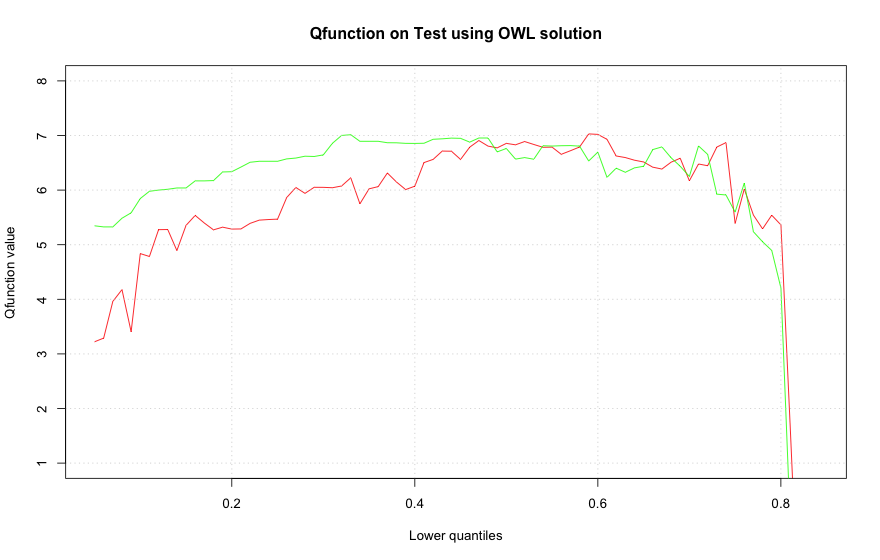

In [451]:
quants = seq(0.05, 0.84, 0.01)
taus = seq(0.05, 0.95, 0.01)
stat = list()
q = 0.6
t = 0.5
for (q in quants) {
# for (t in taus) {
    pars.owl.no.weights <- GetOwlParamsWithoutWeights(train, lambda, q = q, t)  
    pars.owl.weights <- GetOwlParamsWithWeightsAndTau(train, q = q, t)  
    params.list <- list("OWL.reg"=pars.owl.no.weights, "OWL.weights"=pars.owl.weights)
    s = GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
#     s <- cbind(s, pars=params.list)
    stat = rbind(stat, s) 
}
st = data.frame(quantile=quants,  stat)
plot(quants,  unlist(st[, "Qfun.OWL.reg.TEST"]), type="l", ylim=c(1,8), col="red", xlab="", ylab="")
lines(quants, unlist(st[, "Qfun.OWL.weights.TEST"]), type="l", ylim=c(1,8), col="green", xlab="", ylab="")
title("Qfunction on Test using OWL solution", xlab = "Lower quantiles", ylab="Qfunction value")
grid()

#### 2. Initial params with regularization versus params trained with weights and without regularization

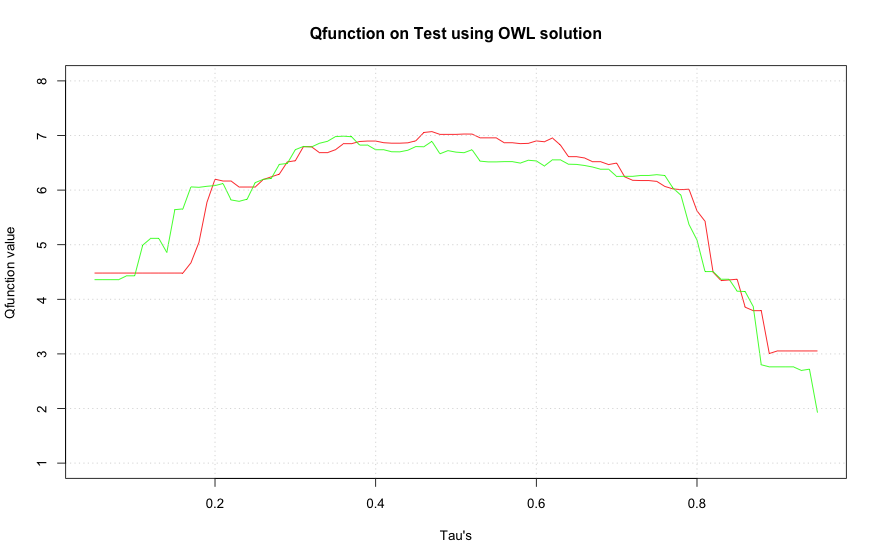

In [452]:
quants = seq(0.05, 0.85, 0.01)
taus = seq(0.05, 0.95, 0.01)
stat = list()
q = 0.6
t = 0.5
# for (q in quants) {
for (t in taus) {
    pars.owl.reg <- GetOwlParamsWithoutWeights(train, lambda, q = q, t)  
    pars.owl.weights <- GetOwlParamsWithWeightsAndTau(train, q = q, t)  
    params.list <- list("OWL.reg"=pars.owl.reg, "OWL.weights"=pars.owl.weights)
    s = GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
#     s <- cbind(s, pars=params.list)
    stat = rbind(stat, s) 
}
st = data.frame(taus=taus,  stat)
plot(taus,  unlist(st[, "Qfun.OWL.reg.TEST"]), type="l", ylim=c(1,8), col="red", xlab="", ylab="")
lines(taus, unlist(st[, "Qfun.OWL.weights.TEST"]), type="l", ylim=c(1,8), col="green", xlab="", ylab="")
title("Qfunction on Test using OWL solution", xlab = "Tau's", ylab="Qfunction value")
grid()

# Why simple quantile regression is the best out of all possible models ? 

In [45]:
train <- GetSimulationData(sample.size, number.of.covariates)
test <- GetSimulationData(test.data.sample.size, number.of.covariates)
data.list <- list("train"=train, "test"=test)
pars.owl <- GetOwlParams(train, lambda, q = 0.6, 0.5) 

In [48]:
q = 0.6
t = 0.5
data = train
constant = min(quantile(data$raw.reward, q), 0)
data$weight = data$raw.reward - constant
index = which(data$raw.reward > quantile(data$raw.reward, q))
rqmodel = rq(data$treatment[index] ~ data$covariates[index, ] - 1, tau = t, method = "lasso", weights = data$weight[index],  lambda = lambda)
coefs = coef(rqmodel)

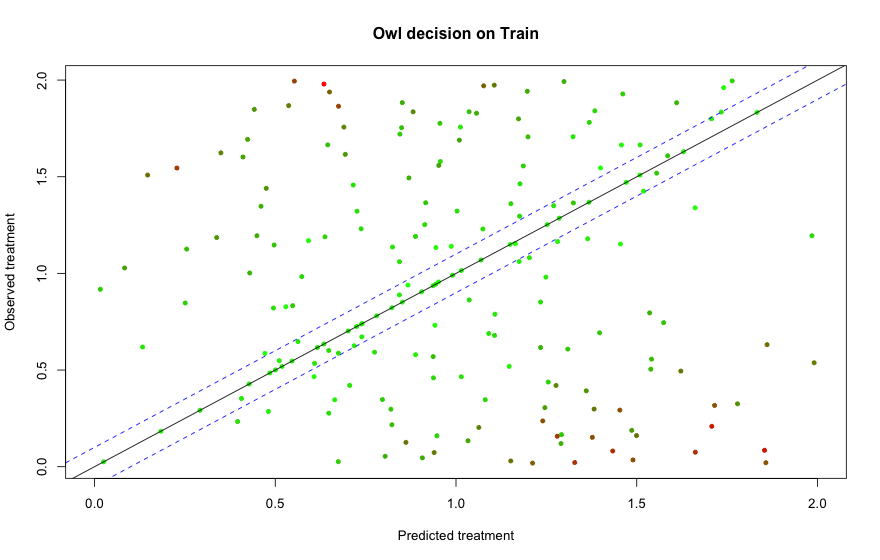

In [49]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, coefs, offset = offset, title = "Owl decision on Train")

In [153]:
quants = seq(0.05, 0.99, 0.01)
taus = seq(0.05, 0.99, 0.01)
stat = list()
q = 0.6
# for (q in quants) {
for (tau in taus) {
     
    s = GetMetricsForParams(list("OWL"=pars.owl), data.list, offset, PolicyFunLinearKernel, lambda)
#     PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")
    s <- cbind(s, pars=list(pars.owl))
    stat = rbind(stat, s) 
}
st = data.frame(quantile=quants,  stat)

In [135]:
# tmp.dir = "/tmp/pngslides/"
# system(paste("mkdir -p ", tmp.dir))
# system(paste("rm -vf ", tmp.dir, "*", sep=""))

# counter = 1
# f <- function(row) {
#     png(paste(tmp.dir, sprintf("%03d", counter), ".png", sep = ""),
#         width = 1000, height = 900, units = "px", pointsize = 17, res=100)
#     PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, as.matrix(unlist(row["pars"])), 
#                                offset=offset, title = paste("Quantile #", row["quantile"]))
#     dev.off()
#     counter <<- counter + 1
# }
# apply(st, 1, f)

# src = paste(tmp.dir, "*.png", sep="")
# dst = paste(tmp.dir, "process.gif", sep="")
# system(paste("convert -delay 20", src, dst))

Warning message:
In plot.window(...): "line" is not a graphical parameterWarning message:
In plot.xy(xy, type, ...): "line" is not a graphical parameterWarning message:
In axis(side = side, at = at, labels = labels, ...): NAs introduced by coercionWarning message:
In axis(side = side, at = at, labels = labels, ...): NAs introduced by coercionWarning message:
In box(...): "line" is not a graphical parameterWarning message:
In title(...): NAs introduced by coercion

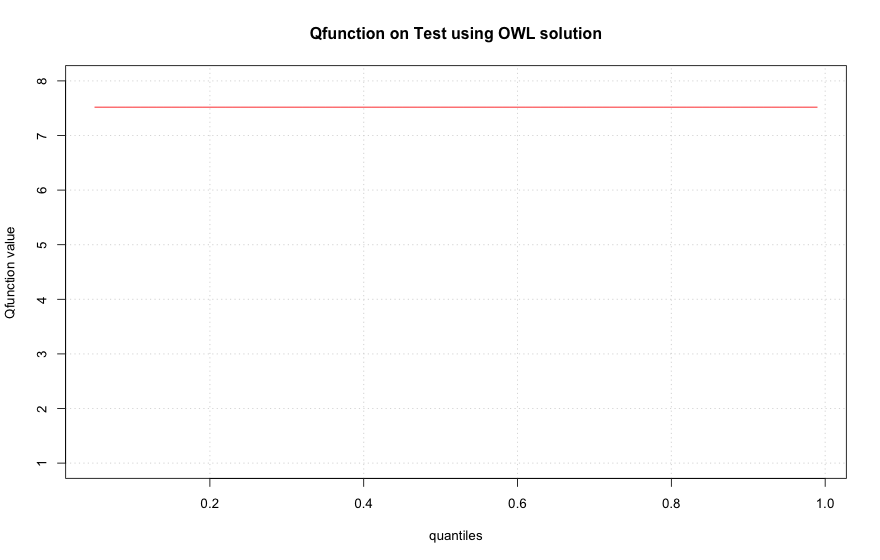

In [155]:
plot(taus, unlist(st[, "Qfun.OWL.TEST"]), type="l", ylim=c(1,8), col=2, xlab="", ylab="", line="Qfunction")
title("Qfunction on Test using OWL solution", xlab = "quantiles", ylab="Qfunction value")
grid()

In [154]:
plot(quants, unlist(s[, "Qfun.OWL.TEST"]), type="l", ylim=c(1,8), col=2, xlab="", ylab="", line="Qfunction")
lines(quants, unlist(s[, "VF.OWL.TEST"]), type="l", col=3, line="Value Functino")
title("Qfunction on Test using OWL solution", xlab = "quantiles", ylab="Qfunction value")
grid()

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


ERROR: Error in xy.coords(x, y): 'x' and 'y' lengths differ


ERROR: Error in title("Qfunction on Test using OWL solution", xlab = "quantiles", : plot.new has not been called yet


ERROR: Error in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...): plot.new has not been called yet


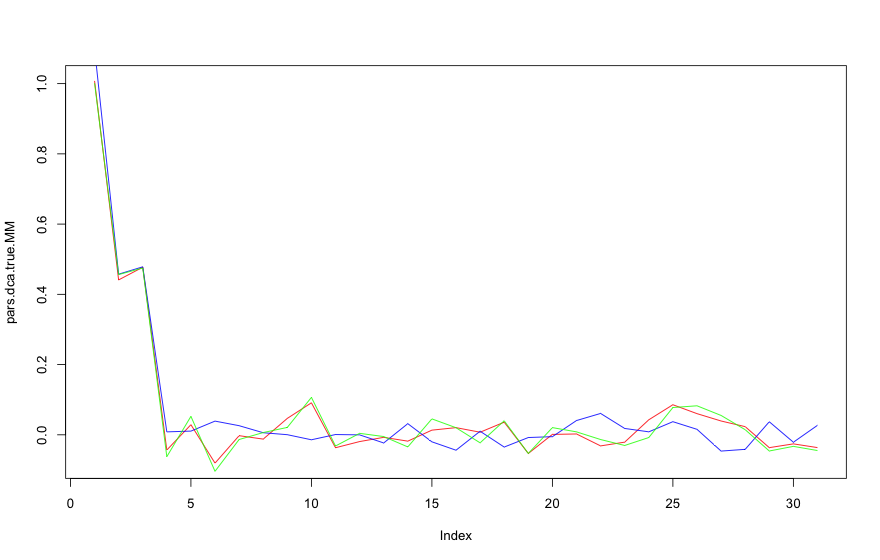

In [67]:
plot(pars.dca.true.MM, col='red', type="l")
lines(pars.dca.true.MM.changed, col='blue')
lines(pars.owl.dc_loop, col='green')
# lines(pars.owl, col='yellow')

Видно, что Kosorok взял квантиль, который очень близко к тому, который доставляет максимум Qfuncion.

In [69]:
s[which.max( unlist(s[, "VF.OWL.TEST"])), ]

quantile VF.OWL.TRAIN OBJF.OWL.TRAIN Qfun.OWL.TRAIN VF.OWL.TEST
36      0.4     6.185906      -27.57669        7.25329    3.855029
   OBJF.OWL.TEST Qfun.OWL.TEST
36     -24.78281      7.388399

# Vusualizations

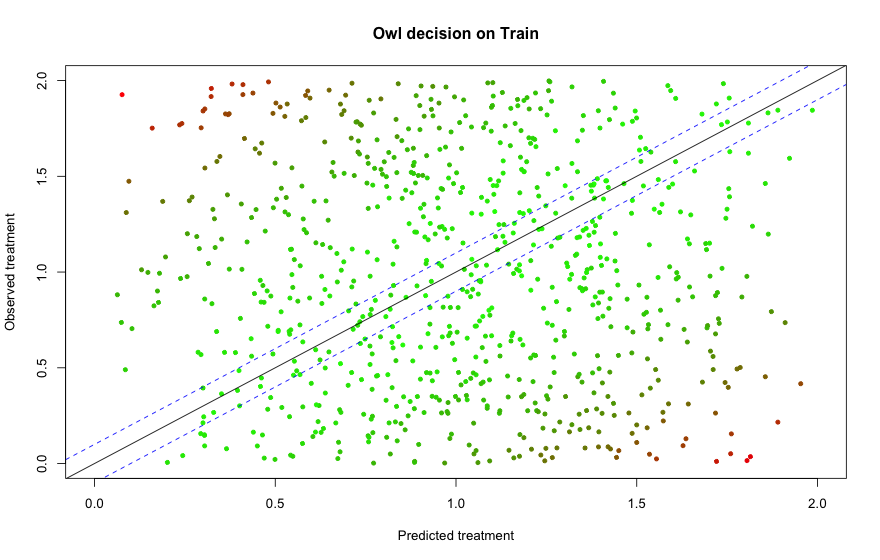

In [141]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, opt.decision, offset = offset, title = "Owl decision on Train")

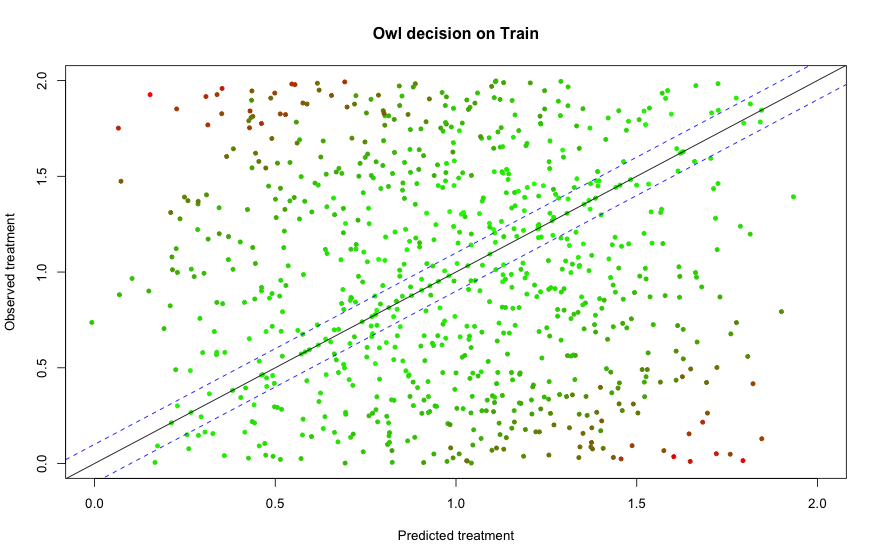

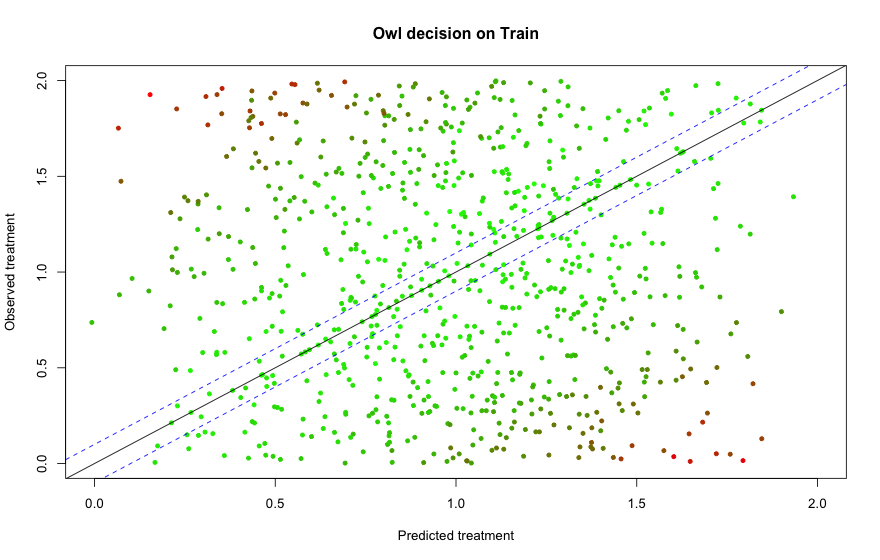

In [144]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on Train")
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, pars.dca.true.MM, offset = offset, title = "Owl decision on Train")

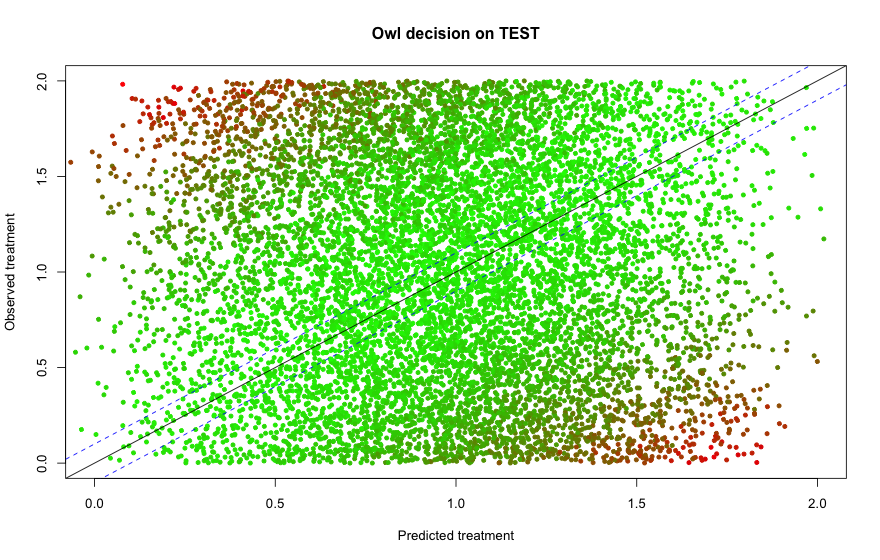

In [143]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.dca.true.MM, offset = offset, title = "Owl decision on TEST")

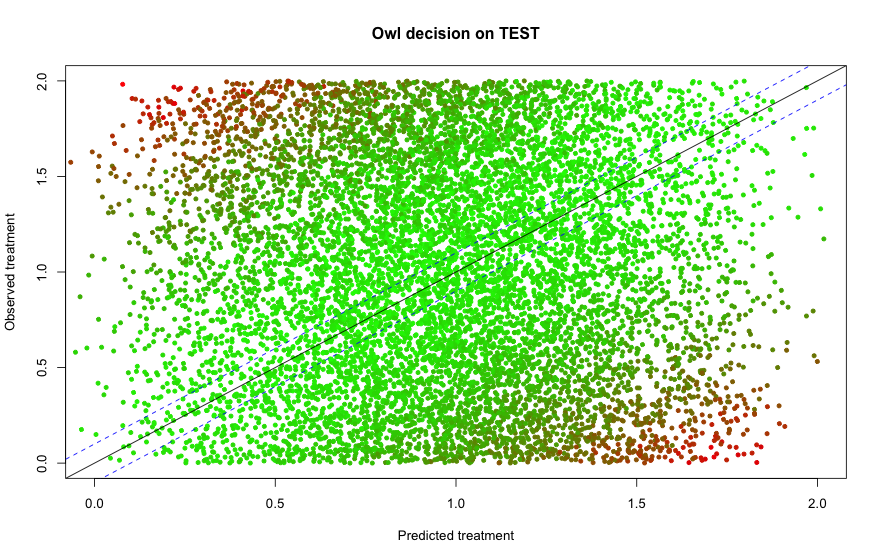

In [142]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")

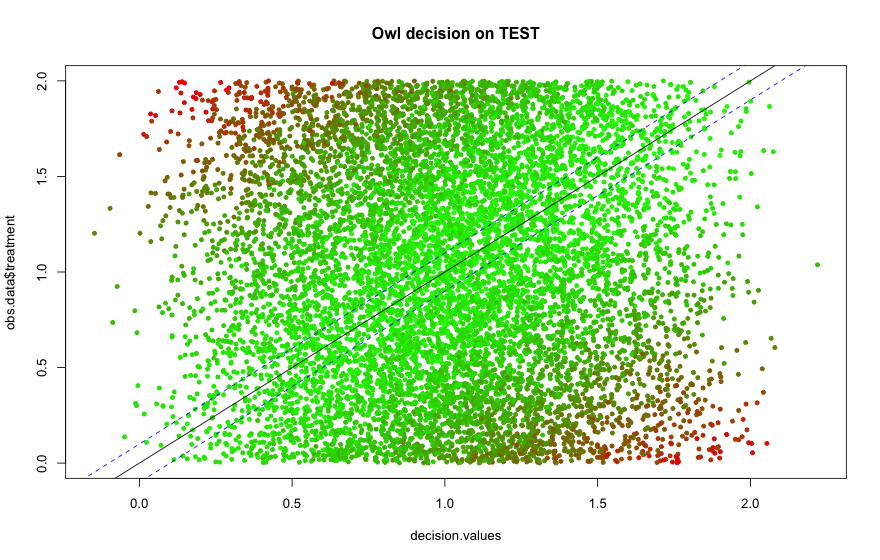

In [71]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.dca.true.MM, offset = offset, title = "Owl decision on TEST")

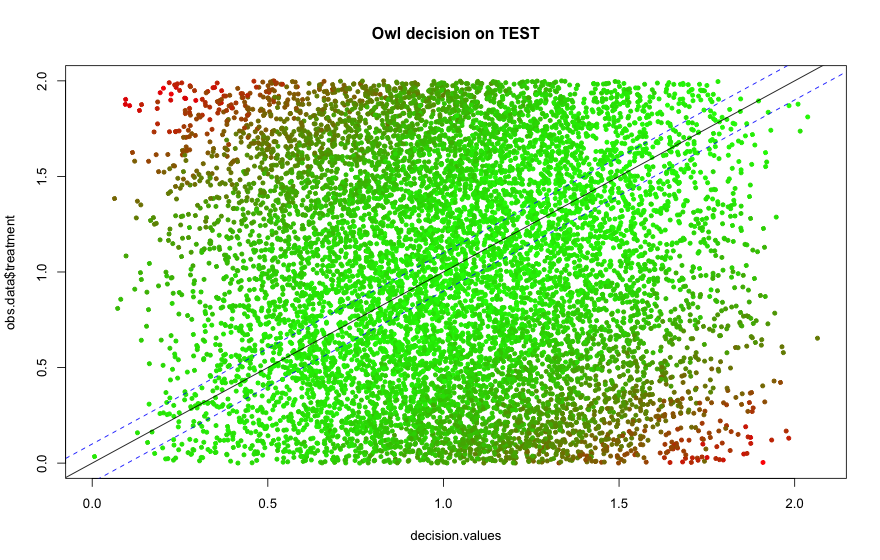

In [211]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.dca.true.MM.changed, offset = offset, title = "Owl decision on TEST")

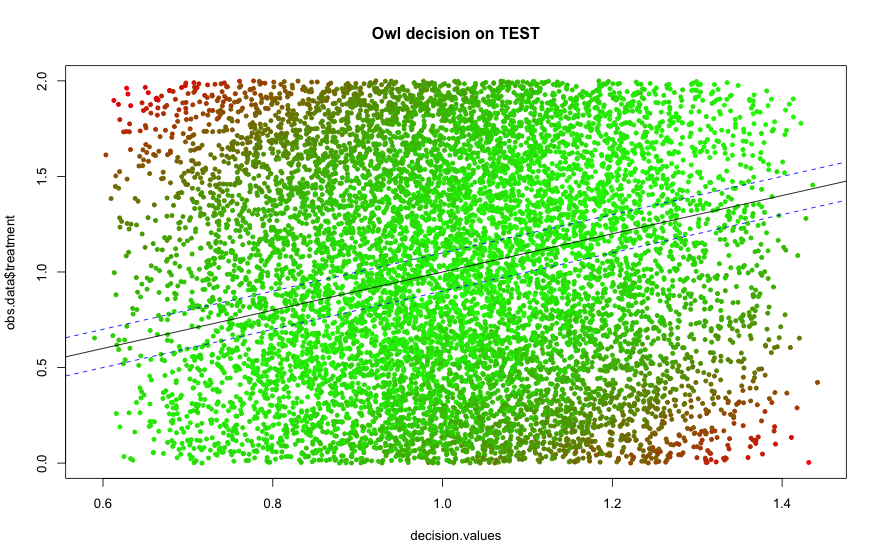

In [212]:
PlotDecsionsVersusObserved(test, PolicyFunLinearKernel, pars.owl.dc_loop, offset = offset, title = "Owl decision on TEST")

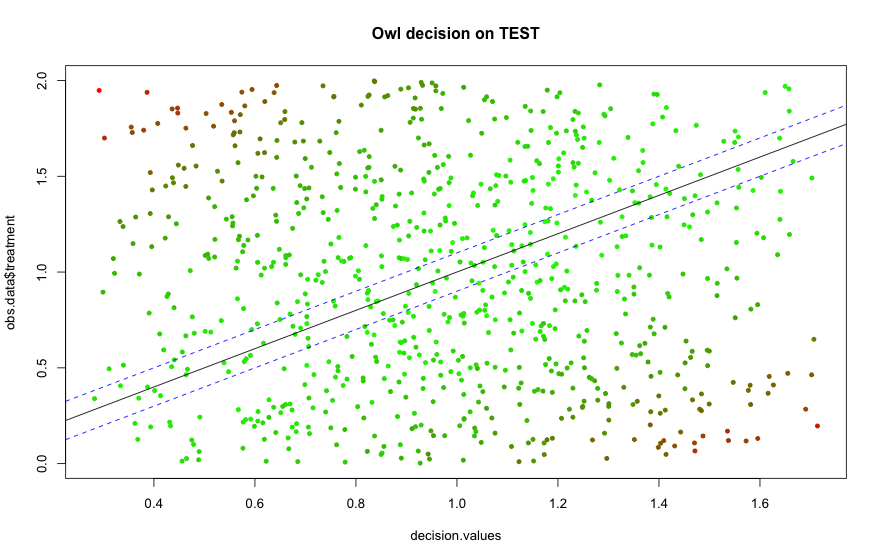

In [43]:
PlotDecsionsVersusObserved(train, PolicyFunLinearKernel, pars.owl, offset = offset, title = "Owl decision on TEST")